In [1]:
import numpy as np
from vowpalwabbit import pyvw
from newsenv import simple_news
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [2]:
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["tod"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [3]:
def run_offline(vw,input_df,actions):       
    for i in range(len(input_df)):
        action = input_df.loc[i, "action"]
        cost = input_df.loc[i, "cost"]
        prob = input_df.loc[i, "prob"]
        user = input_df.loc[i, "user"]
        tod = input_df.loc[i, "tod"]
        context={"user":user,"tod":tod}                    
        vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)            
        vw.learn(vw_format)
    return vw

In [4]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)    
    pmf = vw.predict(vw_text_example)
    chosen_action_index=np.argmax(pmf)    
    return chosen_action_index

In [5]:
def run_eval(agent,env,actions,num_iterations):
    cost_sum = 0.
    ctr = []    
    for i in range(1, num_iterations+1):
        context=env.get_context()       
        action_i = get_action(agent, context, actions)        
        cost = env.get_cost(context, action_i)
        cost_sum += cost
        ctr.append(-1*cost_sum/i)
    return ctr,cost_sum   

In [6]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

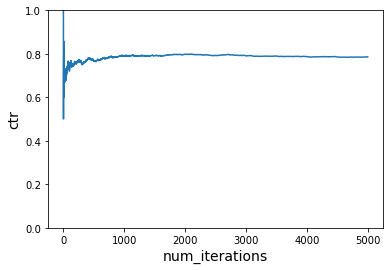

In [7]:
input_df=pd.read_csv('Testdata.csv')
actions = ["politics", "sports", "music", "food", "finance"]
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
agent=run_offline(vw,input_df,actions)
env=simple_news()
num_iterations = 5000
ctr,cost_sum = run_eval(agent,env,actions,num_iterations)
plot_ctr(num_iterations, ctr)